# Code to compute Gaussian and Gauss + SSC covariance matrices for WL, GCph and 3x2pt

Inputs needed: 
* $C_{ij}^{AB}(\ell)$ for WL-WL, GCph-GCph and WL-GCph ("XC")
* $W_i^A(z)$ for WL and GCph (needed for __SSC__)

Outputs (for WL only, GCph only and 3x2pt): 
* Gaussian covariance
* Gauss + SSC covariance


Code can be easily extended to:
* different no. of $z$ bins
* different no. of $\ell$ bins
* different $\ell$ ranges (e.g. intermediate, pessimistic case)

# Step 1: compute Gaussian covariance

Gaussian covariance:
$$Cov[C^{AB}_{ij}(\ell),C^{A'B'}_{kl}(\ell ')] = \left[ \dfrac{[C^{AA'}_{ik}(\ell) + N^{AA'}_{ik}(\ell)][C^{BB'}_{jl}(\ell ') + N^{BB'}_{jl}(\ell ')] + [C^{AB'}_{il}(\ell) + N^{AB'}_{il}(\ell)][C^{BA'}_{jk}(\ell ') + N^{BA'}_{jk}(\ell ')]}{(2\ell +1)f_{sky}\Delta \ell}  \right]\delta^K_{ \ell \ell '}$$

In [1]:
import math ; pi=math.pi
import matplotlib.cm as cm
import numpy as np
import scipy.integrate as integrate
from numba import jit
import matplotlib.pyplot as plt
import time
from pathlib import Path
import sys
path = Path.cwd().parent # get project directory
# import configuration and functions modules
sys.path.append(str(path.parent / 'common_data'))
import my_config
sys.path.append(str(path.parent / 'my_module'))
import my_module as mm

In [2]:
plt.rcParams["figure.figsize"] = (16,9)
#plt.rcParams["uselatex"] = True

params = {'lines.linewidth' : 3,
          'font.size' : 17,
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          # 'mathtext.fontset': 'stix',
          # 'font.family': 'STIXGeneral'
          }

plt.rcParams.update(params)
markersize = 10

### Specify no. of $z$ bins, $(\ell_{min},\ell_{max})$ for the diffferent probes, no. of $\ell$ bins
Note: in the 3x2pt case we're taking the WL probe up to $\ell_{max} = \ell_{max}^{GC}$, then we compute a separate covariance matrix taking only the excess bins from $\ell_{max}^{GC}$ to $\ell_{max}^{WL}$ (__WA__, for "WL-add")

In [3]:
zbins   = my_config.zbins
nbl = my_config.nbl
Cij_folder = my_config.Cij_folder

ell_min = my_config.ell_min
ell_max_WL = my_config.ell_max_WL
ell_max_GC = my_config.ell_max_GC
ell_max_XC = ell_max_GC
ell_max_WA = ell_max_GC 

nProbes = my_config.nProbes

survey_area = 15000 # deg^2
deg2_in_sphere = 41252.96 # deg^2 in a spere
fsky = survey_area/deg2_in_sphere

# redshift pairs
npairs  = int((zbins*(zbins+1))/2) # = 55, cast it as int
npairs_asimm = zbins**2
npairs_tot = 2*npairs + npairs_asimm
    
print(f"check: \nzbins = {zbins} \nnbl = {nbl} \nell_max_WL = {ell_max_WL} \nell_max_GC = {ell_max_GC} \nfsky = {fsky}")

check: 
zbins = 10 
nbl = 30 
ell_max_WL = 5000 
ell_max_GC = 3000 
fsky = 0.3636102718447355


### The "ind" array maps indices of 2D matrix into indices of pairs: $C_{ij}(\ell) \leftrightarrow C_{p}(\ell)$

In [4]:
# indices array
ind = np.genfromtxt(path.parent / "common_data/indici.dat")
ind = ind.astype(int)
ind = ind - 1 

In [5]:
print(ind)

[[0 0 0 0]
 [0 0 1 0]
 [0 0 1 1]
 [0 0 2 0]
 [0 0 2 1]
 [0 0 2 2]
 [0 0 3 0]
 [0 0 3 1]
 [0 0 3 2]
 [0 0 3 3]
 [0 0 4 0]
 [0 0 4 1]
 [0 0 4 2]
 [0 0 4 3]
 [0 0 4 4]
 [0 0 5 0]
 [0 0 5 1]
 [0 0 5 2]
 [0 0 5 3]
 [0 0 5 4]
 [0 0 5 5]
 [0 0 6 0]
 [0 0 6 1]
 [0 0 6 2]
 [0 0 6 3]
 [0 0 6 4]
 [0 0 6 5]
 [0 0 6 6]
 [0 0 7 0]
 [0 0 7 1]
 [0 0 7 2]
 [0 0 7 3]
 [0 0 7 4]
 [0 0 7 5]
 [0 0 7 6]
 [0 0 7 7]
 [0 0 8 0]
 [0 0 8 1]
 [0 0 8 2]
 [0 0 8 3]
 [0 0 8 4]
 [0 0 8 5]
 [0 0 8 6]
 [0 0 8 7]
 [0 0 8 8]
 [0 0 9 0]
 [0 0 9 1]
 [0 0 9 2]
 [0 0 9 3]
 [0 0 9 4]
 [0 0 9 5]
 [0 0 9 6]
 [0 0 9 7]
 [0 0 9 8]
 [0 0 9 9]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 0 2]
 [1 0 0 3]
 [1 0 0 4]
 [1 0 0 5]
 [1 0 0 6]
 [1 0 0 7]
 [1 0 0 8]
 [1 0 0 9]
 [1 0 1 0]
 [1 0 1 1]
 [1 0 1 2]
 [1 0 1 3]
 [1 0 1 4]
 [1 0 1 5]
 [1 0 1 6]
 [1 0 1 7]
 [1 0 1 8]
 [1 0 1 9]
 [1 0 2 0]
 [1 0 2 1]
 [1 0 2 2]
 [1 0 2 3]
 [1 0 2 4]
 [1 0 2 5]
 [1 0 2 6]
 [1 0 2 7]
 [1 0 2 8]
 [1 0 2 9]
 [1 0 3 0]
 [1 0 3 1]
 [1 0 3 2]
 [1 0 3 3]
 [1 0 3 4]
 [1 0 3 5]

### Load $\ell$ and $\Delta\ell$ from previous script


In [6]:
# import ell values
ell_WL = np.genfromtxt(f"{path}/output/ell_values/ell_WL_ellMaxWL{ell_max_WL}_nbl{nbl}.txt")
ell_GC = np.genfromtxt(f"{path}/output/ell_values/ell_GC_ellMaxGC{ell_max_GC}_nbl{nbl}.txt")
ell_WA = np.genfromtxt(f"{path}/output/ell_values/ell_WA_ellMaxWA{ell_max_WA}_nbl{nbl}.txt")

# nbl for Wadd
if ell_WA.size == 1: # in the case of just one bin it would give error
    nbl_WA = 1
else:
    nbl_WA = ell_WA.shape[0]

# and deltas
l_lin_WL = 10**ell_WL
l_lin_GC = 10**ell_GC
l_lin_WA = 10**ell_WA
l_lin_XC = l_lin_GC

delta_l_WL = np.genfromtxt(f"{path}/output/ell_values/delta_l_WL_ellMaxWL{ell_max_WL}_nbl{nbl}.txt")
delta_l_GC = np.genfromtxt(f"{path}/output/ell_values/delta_l_GC_ellMaxGC{ell_max_GC}_nbl{nbl}.txt")
delta_l_WA = np.genfromtxt(f"{path}/output/ell_values/delta_l_WA_ellMaxWA{ell_max_WA}_nbl{nbl}.txt")
delta_l_XC = delta_l_GC # ALL

### Import $C_{ij}(\ell)$

In [7]:
C_LL = np.load(f"{path}/output/matrici_base/common_ell_and_deltas/{Cij_folder}/C_LL_nbl{nbl}_lmaxWL{ell_max_WL}_WLonly.npy")
C_GG = np.load(f"{path}/output/matrici_base/common_ell_and_deltas/{Cij_folder}/C_GG_nbl{nbl}_lmaxGC{ell_max_GC}_GConly.npy")
C_WA = np.load(f"{path}/output/matrici_base/common_ell_and_deltas/{Cij_folder}/C_WA_nbl{nbl}_lmaxWL{ell_max_WL}_WLadd.npy")
# datavector (ALL)
D_ALL= np.load(f"{path}/output/matrici_base/common_ell_and_deltas/{Cij_folder}/D_all_nbl{nbl}_lmaxWL{ell_max_WL}.npy")

print('C_LL and C_GG shape:', C_LL.shape)
print('3x2pt datavector shape:', D_ALL.shape)


C_LL and C_GG shape: (30, 10, 10)
3x2pt datavector shape: (30, 2, 2, 10, 10)


### Define noise terms:
$$N^{LL}_{ij}(\ell) = \dfrac{\sigma_\epsilon^2}{\bar{n}}\delta^K_{ij}$$

$$N^{GG}_{ij}(\ell) = \dfrac{1}{\bar{n}}\delta^K_{ij}$$

$$N^{LG}_{ij}(\ell) = N^{GL}_{ij}(\ell) = 0$$

In [8]:
# parameters needed
sigma_eps2 = 0.09
ng = 30 # number of galaxies per arcmin^2 (constant)
conversion_factor = 11818102.860035626 # deg to arcmin^2
fraction = 1/zbins
n_bar = ng*conversion_factor*fraction

# create the arrays
N_LL = np.zeros((zbins, zbins))
N_GG = np.zeros((zbins, zbins))
N_LG = 0
N    = np.zeros((nProbes, nProbes, zbins, zbins))

# fill the arrays
for i in range(zbins):
    for j in range(zbins):
        if (i==j):
            N_LL[i,j] = (sigma_eps2)/n_bar
            N_GG[i,j] = 1/n_bar
        else:
            N_LL[i,j] = 0
            N_GG[i,j] = 0
# symmetrize
for i in range(zbins):
    for j in range(zbins):
        N[0,0,i,j] = N_LL[i,j]
        N[1,1,i,j] = N_GG[i,j]

### Compute Gaussian Covariance for all probes

In [9]:
start_time = time.time()

# WL only covariance
cov_WL_Gauss = mm.covariance(nbl = nbl, npairs = npairs, start_index = 0, stop_index = npairs,\
                             Cij = C_LL, noise = N, l_lin = l_lin_WL,\
                             delta_l = delta_l_WL, fsky = fsky, ind = ind)
# GC only covariance
starting_GC_index = npairs + npairs_asimm
cov_GC_Gauss = mm.covariance(nbl = nbl, npairs = npairs, start_index = starting_GC_index, stop_index = npairs_tot,\
                             Cij = C_GG, noise = N, l_lin = l_lin_GC,\
                             delta_l = delta_l_GC, fsky = fsky, ind = ind)
# ALL covariance
cov_ALL_Gauss = mm.covariance_ALL(nbl = nbl, npairs = npairs_tot, start_index = 0, stop_index = npairs_tot,\
                                  Cij = D_ALL, noise = N, l_lin = l_lin_XC,\
                                  delta_l = delta_l_XC, fsky = fsky, ind = ind)
# WA covariance
cov_WA_Gauss = mm.covariance_WA(nbl_WA, npairs, start_index = 0, stop_index = npairs,\
                                Cij = C_WA, noise = N, l_lin = l_lin_WA,\
                                delta_l = delta_l_WA, fsky = fsky, ind = ind, ell_WA = ell_WA)
print("Gaussian covariance matrices computed in %.2f seconds" %(time.time() - start_time))

Gaussian covariance matrices computed in 1.47 seconds


### Function for 3x2pt (use `@jit`! http://numba.pydata.org/)

<br>
$$Cov[C^{AB}_{ij}(\ell),C^{A'B'}_{kl}(\ell ')] = \left[ \dfrac{[C^{AA'}_{ik}(\ell) + N^{AA'}_{ik}(\ell)][C^{BB'}_{jl}(\ell ') + N^{BB'}_{jl}(\ell ')] + [C^{AB'}_{il}(\ell) + N^{AB'}_{il}(\ell)][C^{BA'}_{jk}(\ell ') + N^{BA'}_{jk}(\ell ')]}{(2\ell +1)f_{sky}\Delta \ell}  \right]\delta^K_{ \ell \ell '}$$

In [10]:
@jit(nopython=True)
def covariance_ALL(nbl, npairs, start_index, stop_index, Cij, noise, l_lin, delta_l, fsky, ind):
    
    # create covariance array
    covariance = np.zeros((nbl, nbl, npairs, npairs))
    
    # compute cov(ell, p, q)
    for ell in range(nbl):
        for p in range(start_index, stop_index):
            for q in range(start_index, stop_index):
                covariance[ell, ell, p - start_index, q - start_index] = \
                     ((Cij[ell,ind[p,0],ind[q,0],ind[p,2],ind[q,2]] + noise[ind[p,0],ind[q,0],ind[p,2],ind[q,2]])*\
                      (Cij[ell,ind[p,1],ind[q,1],ind[p,3],ind[q,3]] + noise[ind[p,1],ind[q,1],ind[p,3],ind[q,3]])+\
                      (Cij[ell,ind[p,0],ind[q,1],ind[p,2],ind[q,3]] + noise[ind[p,0],ind[q,1],ind[p,2],ind[q,3]])*\
                      (Cij[ell,ind[p,1],ind[q,0],ind[p,3],ind[q,2]] + noise[ind[p,1],ind[q,0],ind[p,3],ind[q,2]]))/\
                      ((2*l_lin[ell]+1)*fsky*delta_l[ell])
                         #         A        B        i        j                 A        B       i        j
    return covariance

### Save matrices (npy, dat or txt)

In [11]:
np.save(f"{path}/output/covmat/common_ell_and_deltas/{Cij_folder}/demo/covmat_WLonly_lmin{ell_min}_lmaxWL{ell_max_WL}_nbl{nbl}.npy", cov_WL_Gauss)
np.save(f"{path}/output/covmat/common_ell_and_deltas/{Cij_folder}/demo/covmat_GConly_lmin{ell_min}_lmaxGC{ell_max_GC}_nbl{nbl}.npy", cov_GC_Gauss)
np.save(f"{path}/output/covmat/common_ell_and_deltas/{Cij_folder}/demo/covmat_ALL_lmin{ell_min}_lmaxXC{ell_max_XC}_nbl{nbl}.npy", cov_ALL_Gauss)
np.save(f"{path}/output/covmat/common_ell_and_deltas/{Cij_folder}/demo/covmat_WA_lmin{ell_min}_lmaxWL{ell_max_WL}_nbl{nbl}.npy", cov_WA_Gauss)
print('saved')
print(r'size of the 3x2pt matrix: about 300 MB (nbl = %i, zbins = %i)' %(nbl, zbins))
print('3x2pt covariance shape:', cov_ALL_Gauss.shape)

saved
size of the 3x2pt matrix: about 300 MB (nbl = 30, zbins = 10)
3x2pt covariance shape: (30, 30, 210, 210)


# Step 2: compute Gauss + SSC covariance

### Fast SSC: (Lacasa & Grain, arXiv:1809.05437):

Approximation used: the response of the probe, which amounts how a given probe varies with changes of the background density $\delta_b$, vary slowly with redshift compared to $\sigma^2(z_1,z_2)$ 

<br>
$$Cov_{G+SSC} = Cov_{G} + Cov_{SSC}$$
<br>
$$    Cov_{SSC}[C^{AB}_{ij}(\ell),C^{CD}_{kl}(\ell ')] \simeq R^{AB}(\ell)C^{AB}_{ij}(\ell)R^{CD}(\ell)C^{CD}_{kl}(\ell ')S^{A,B;C,D}_{i,j;k,l} \times f_{sky}^{-1} $$

With:
* $ R^{AB}(\ell)$: effective relative response of the PS between probes A and B to a change in bg density (taken constant = 4)
* $S^{A,B;C,D}_{i,j;k,l}$ (from here on $S_{ijkl}$): dimensionless volume-averaged (co)variance of the background matter density contrast

$$S_{i_{z}, j_{z} ; k_{z}, l_{z}}^{A, B ; C, D}=\int \mathrm{d} V_{1} \mathrm{~d} V_{2} \frac{W_{i_{z}}^{A}\left(z_{1}\right) W_{j_{z}}^{B}\left(z_{1}\right)}{I^{A B}\left(i_{z}, j_{z}\right)} \frac{W_{k_{z}}^{C}\left(z_{2}\right) W_{l_{z}}^{D}\left(z_{2}\right)}{I^{C D}\left(k_{z}, l_{z}\right)} \sigma^{2}\left(z_{1}, z_{2}\right)$$

* $\text d V = \chi^2(z) \frac{\text d \chi }{ \text d z} \text d z$ comoving volume per steradian
* $\sigma^2(z_1,z_2)$: change in the background density 
on a given survey volume due to 
super-survey modes modulations 


$$\sigma^2(z_1,z_2) = \dfrac{1}{2\pi^2}\int
k^2\text {d} k P_m(k|z_{12})j_0(k\chi_1)j_0(k\chi_2)$$

* $I^{AB}(i_z,j_z)$: normalization factor

$$    I^{AB}(i_z,j_z)= \int \mathrm{d} V_1 W^A_{i_z}(z_1) W^B_{j_z}(z_1)$$

## 2.1: Compute $S_{ijkl}$

### Define $S_{ijkl}$ routine (from [PySSC](https://github.com/fabienlacasa/PySSC))

(need to install `classy`, the Python wrapper for `CLASS` (install from [GitHub](https://github.com/lesgourg/class_public) or with `pip install classy` command)


**No need to re-compute $S_{ijkl}$ for varying $\ell$ range and/or no. of $\ell$ bins**

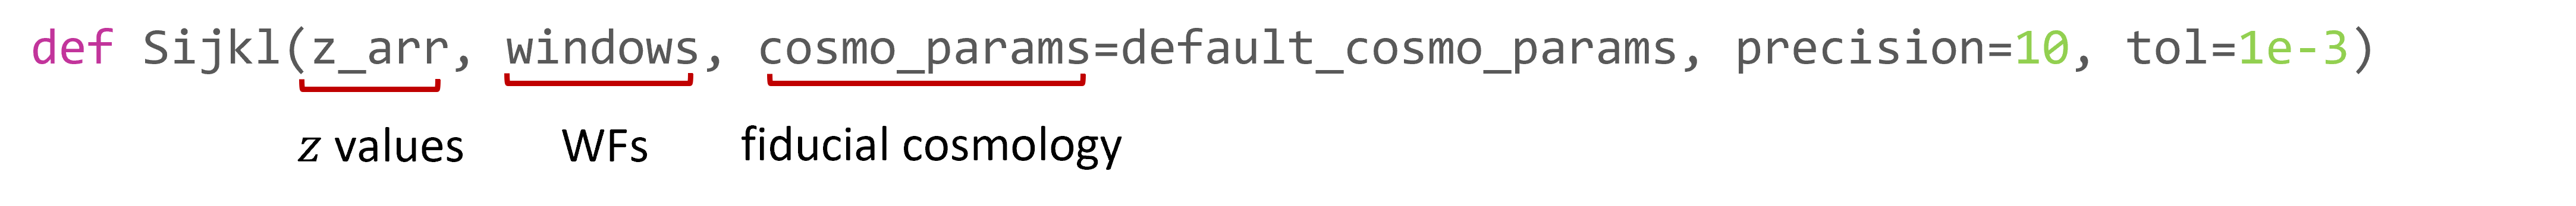

__3 inputs needed for Sijkl:__
* fiducial cosmological parameters vector (in the form of a dictionary)
* Window functions $W^A_i(z)$
* corresponding $z$ values

In [12]:
# from classy import Class

In [13]:
#################### DEFINING THE Sijkl FUNCTION ##############################

# Routine to compute the Sijkl matrix, i.e. the most general case with cross-spectra
# Inputs : window functions, cosmological parameters, same format as Sij()
# Format for window functions : one table of redshifts with size nz, one 2D table 
# for the collection of window functions with shape (nbins,nz)
# Output : Sijkl matrix (shape: nbins x nbins x nbins x nbins)
# Equation used :  Sijkl = 1/(2*pi^2) \int kk^2 dkk P(kk) U(i,j;kk)/Inorm(i,j) U(k,l;kk)/Inorm(k,l)
# with Inorm(i,j) = int dV window(i,z) window(j,z) and U(i,j;kk) = int dV window(i,z) window(j,z) growth(z) j_0(kk*r)

# tol: upper limit on I(i,j)/sqrt(I(i,i), I(j,j)); necessary for making Sijkl between slighlty overlapping bins = 0
# precision: nk = 2**precision = no. of values in the k grid
def Sijkl_function(z_arr, windows, cosmo_params, precision=10, tol=1e-3):
    
    # Assert everything as the good type and shape, and find number of redshifts, bins etc
    zz  = np.asarray(z_arr)
    win = np.asarray(windows)
    
    assert zz.ndim==1, 'z_arr must be a 1-dimensional array'
    assert win.ndim==2, 'windows must be a 2-dimensional array'
    
    nz    = len(zz)          
    nbins = win.shape[0]     
    assert win.shape[1]==nz, 'windows must have shape (nbins,nz)'
    
    assert zz.min()>0, 'z_arr must have values > 0'
    
    # Run CLASS
    cosmo = Class()
    dico_for_CLASS = cosmo_params
    dico_for_CLASS['output'] = 'mPk'
    cosmo.set(dico_for_CLASS)
    cosmo.compute() 
    h = cosmo.h() #for  conversions Mpc/h <-> Mpc

    
    # Define arrays of r(z), k, P(k)...
    zofr        = cosmo.z_of_r(zz)
    comov_dist  = zofr[0]                                   #Comoving distance r(z) in Mpc
    dcomov_dist = 1/zofr[1]                                 #Derivative dr/dz in Mpc
    dV          = comov_dist**2 * dcomov_dist               #Comoving volume per solid angle in Mpc^3/sr
    growth      = np.zeros(nz)                              #Growth factor
    for iz in range(nz):
        growth[iz] = cosmo.scale_independent_growth_factor(zz[iz])

    #Index pairs of bins
    npairs      = (nbins*(nbins+1))//2
    pairs       = np.zeros((2,npairs),dtype=int)
    count       = 0
    for ibin in range(nbins):
        for jbin in range(ibin,nbins):
            pairs[0,count] = ibin
            pairs[1,count] = jbin
            count +=1
        
    # Compute normalisations
    Inorm       = np.zeros(npairs)
    Inorm2D     = np.zeros((nbins,nbins))
    for ipair in range(npairs):
        ibin               = pairs[0,ipair]
        jbin               = pairs[1,ipair]
        integrand          = dV * windows[ibin,:]* windows[jbin,:]
        integral           = integrate.simps(integrand,zz)
        Inorm[ipair]       = integral
        Inorm2D[ibin,jbin] = integral
        Inorm2D[jbin,ibin] = integral
    #Flag pairs with too small overlap as unreliable
    #Note: this will also speed up later computations
    #Default tolerance : tol=1e-3
    flag        = np.zeros(npairs,dtype=int)
    for ipair in range(npairs):
        ibin               = pairs[0,ipair]
        jbin               = pairs[1,ipair]
        ratio              = abs(Inorm2D[ibin,jbin])/np.sqrt(abs(Inorm2D[ibin,ibin]*Inorm2D[jbin,jbin]))
        if ratio<tol:
            flag[ipair]=1
    
    # Compute U(i,j;kk)
    keq         = 0.02/h                                          #Equality matter radiation in 1/Mpc (more or less)
    klogwidth   = 10                                              #Factor of width of the integration range. 10 seems ok
    kmin        = min(keq,1./comov_dist.max())/klogwidth
    kmax        = max(keq,1./comov_dist.min())*klogwidth
    nk          = 2**precision                                    #10 seems to be enough. Increase to test precision, reduce to speed up.
    #kk          = np.linspace(kmin,kmax,num=nk)                   #linear grid on k
    logkmin     = np.log(kmin) ; logkmax   = np.log(kmax)
    logk        = np.linspace(logkmin,logkmax,num=nk)
    kk          = np.exp(logk)                                     #logarithmic grid on k    
    Pk          = np.zeros(nk)
    
    # kmin = 1.36284678e-05 1/Mpc
    # kmax = 2.2354 1/Mpc
    
    for ik in range(nk):
        Pk[ik]  = cosmo.pk(kk[ik],0.)                              #In Mpc^3
    Uarr        = np.zeros((npairs,nk))
    for ipair in range(npairs):
        if flag[ipair]==0:
            ibin = pairs[0,ipair]
            jbin = pairs[1,ipair]
            for ik in range(nk):
                kr             = kk[ik]*comov_dist
                integrand      = dV * windows[ibin,:] * windows[jbin,:] * growth * np.sin(kr)/kr
                Uarr[ipair,ik] = integrate.simps(integrand,zz)
            
    # Compute Sijkl finally
    Sijkl      = np.zeros((nbins,nbins,nbins,nbins))
    #For ipair<=jpair
    for ipair in range(npairs):
        if flag[ipair]==0:
            U1 = Uarr[ipair,:]/Inorm[ipair]
            ibin = pairs[0,ipair]
            jbin = pairs[1,ipair]
            for jpair in range(ipair,npairs):
                if flag[jpair]==0:
                    U2 = Uarr[jpair,:]/Inorm[jpair]
                    kbin = pairs[0,jpair]
                    lbin = pairs[1,jpair]
                    integrand = kk**2 * Pk * U1 * U2
                    #integral = 1/(2*pi**2) * integrate.simps(integrand,kk)     #linear integration
                    integral = 1/(2*pi**2) * integrate.simps(integrand*kk,logk) #log integration
                    #Run through all valid symmetries to fill the 4D array
                    #Symmetries: i<->j, k<->l, (i,j)<->(k,l)
                    Sijkl[ibin,jbin,kbin,lbin] = integral
                    Sijkl[ibin,jbin,lbin,kbin] = integral
                    Sijkl[jbin,ibin,kbin,lbin] = integral
                    Sijkl[jbin,ibin,lbin,kbin] = integral
                    Sijkl[kbin,lbin,ibin,jbin] = integral
                    Sijkl[kbin,lbin,jbin,ibin] = integral
                    Sijkl[lbin,kbin,ibin,jbin] = integral
                    Sijkl[lbin,kbin,jbin,ibin] = integral 

    return Sijkl

### Choose fiducial cosmology

In [14]:
Omega_b = 0.05
Omega_m = 0.32
h       = 0.67
n_s     = 0.96
sigma8  = 0.816

# neutrinos
m_ncdm  = 0.06
N_ncdm = 1
N_ur   = 2.03351
Omega_ni  = m_ncdm/(93.14*h*h)

# DE
Omega_Lambda = 0.68 
w0_fld = -1
wa_fld = 0

Omega_cdm = Omega_m - Omega_b - Omega_ni
k_max  = 30



default_cosmo_params = {'output':'mPk', 
                        'Omega_b':Omega_b,
                        'Omega_cdm':Omega_cdm,
                        'h':h,
                        'sigma8':sigma8,
                        'n_s':n_s,
                        'P_k_max_1/Mpc':k_max,
                        'N_ncdm': N_ncdm,
                        'm_ncdm': m_ncdm,
                        'N_ur': N_ur,      
                        'Omega_Lambda': Omega_Lambda, 
                        'w0_fld': w0_fld,
                        'wa_fld': wa_fld   
                        }

### Window functions

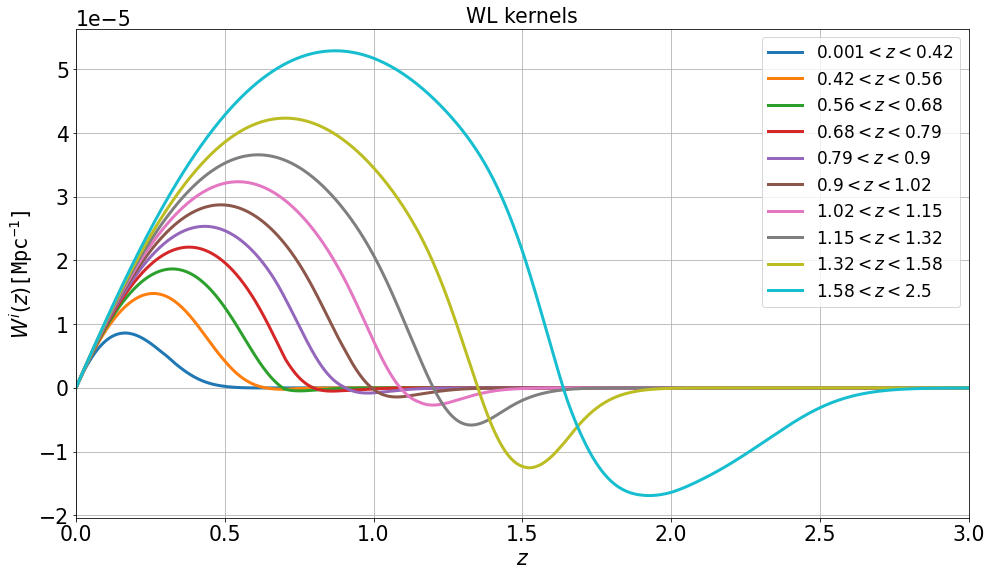

In [41]:
wil = np.genfromtxt(path.parent / f"common_data/everyones_WF_from_Gdrive/WF/davide/nz10000/wil_dav_IA_IST_nz10000.txt")
wig = np.genfromtxt(path.parent / f"common_data/everyones_WF_from_Gdrive/WF/davide/nz10000/wig_dav_IST_nz10000.txt")

zbins = 10
z_edges = [0.0010, 0.42, 0.56, 0.68, 0.79, 0.90, 1.02, 1.15, 1.32, 1.58, 2.50]

# lensing
for i in range(zbins):
    plt.plot(wil[:,0], wil[:,i+1], label = f'${z_edges[i]} < z < {z_edges[i+1]}$')
plt.grid()
plt.xlim((0,3))
#plt.legend(bbox_to_anchor=[1, 0.3])
plt.legend()

plt.xlabel('$z$')
plt.ylabel('$W^i(z) \\tt{[Mpc^{-1}]}$')
plt.title('WL kernels')
plt.savefig(f'{path}/output/plots/wil_dav_IA_IST_nz10000.png')

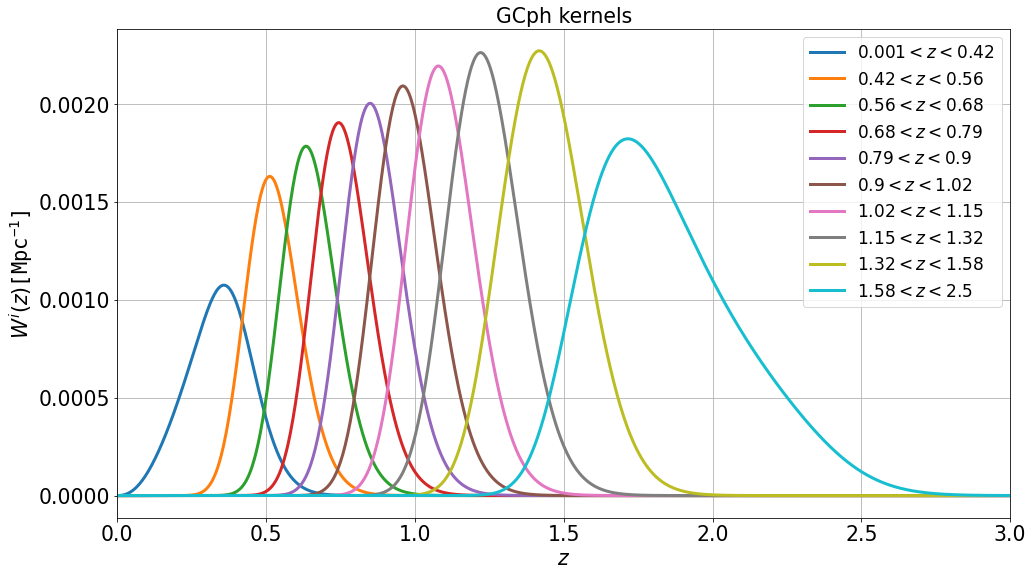

In [40]:
# GCph
for i in range(zbins):
    plt.plot(wig[:,0], wig[:,i+1], label = f'${z_edges[i]} < z < {z_edges[i+1]}$')
plt.grid()
#plt.legend(bbox_to_anchor=[1, 0.3])
plt.legend()

plt.xlim((0,3))
plt.xlabel('$z$')
plt.ylabel('$W^i(z) \\tt{[Mpc^{-1}]}$')
plt.title('GCph kernels')

plt.savefig(f'{path}/output/plots/wig_dav_IST_nz10000.png', bbox_inches='tight')

### Load the Window Functions (PySSC <span style="color:red">convention</span>)


Possibility to specify the convention used in the latest version of the code. In general, we have:

$$W_{\mathrm{PySSC}}^{\mathrm{GC}}(z) = W_{\text {IST }}^{\mathrm{GC}}(z) \big / \chi^{2}$$ \
$$W_{\mathrm{PySSC}}^{\mathrm{WL}}(z) = W_{\mathrm{IST}}^{WL}(z) \big / \chi^{2} $$

In [17]:
wil = np.genfromtxt(path.parent / f"common_data/everyones_WF_from_Gdrive/WF/davide/nz10000/wil_dav_IA_PySSC_nz10000.txt")
wig = np.genfromtxt(path.parent / f"common_data/everyones_WF_from_Gdrive/WF/davide/nz10000/wig_dav_PySSC_nz10000.txt")
fileName = f"Sijkl_WFdavide_nz10000_IA_demo.npy"
print('WF shape:', wil.shape, '(z points, z bins + 1)')

WF shape: (10000, 11) (z points, z bins + 1)


### <span style="color:red">high number of points</span> in redshift grid

In [18]:
# set the redshift array, z_arr
z_arr = wil[:,0]
print('number of points in the z grid:', z_arr.shape[0])

number of points in the z grid: 10000


In [19]:
# delete the redshift column (0-th column):
wil = np.delete(wil, 0, axis=1)
wig = np.delete(wig, 0, axis=1)
print('WF shape:', wil.shape)

WF shape: (10000, 10)


In [20]:
# transpose
wil = np.transpose(wil)
wig = np.transpose(wig)

# vertically stack the WFs (row-wise, wil first, wig second)
w = np.vstack((wil, wig))
windows = w
print('WF shape:', windows.shape)

WF shape: (20, 10000)


### Compute $S_{ijkl}$

In [21]:
# call the routine
# start_time = time.time()
# Sijkl    = Sijkl_function(z_arr, windows, cosmo_params = default_cosmo_params, precision=10, tol=1e-3)

# print("Sijkl matrix computed in %.1f seconds" %(time.time() - start_time))
# np.save(f"{path}/output/Sijkl_everyonesWF/no_z_interpolation/PySSC_demo/{fileName}", Sijkl)

In [22]:
print('Sijkl computation time for 3x2pt: around 110 seconds')
Sijkl = np.load(path.parent / f"common_data/Sijkl/Sijkl_WFdavide_nz10000_IA_3may.npy")
print('Sikjl shape:', Sijkl.shape, '= (2*nzbins, 2*nzbins, 2*nzbins, 2*nzbins)')

Sijkl computation time for 3x2pt: around 110 seconds
Sikjl shape: (20, 20, 20, 20) = (2*nzbins, 2*nzbins, 2*nzbins, 2*nzbins)


### Recast Sijkl as a matrix of pairs

bins far enough apart have basically no overlap so the cross-spectra is zero. If the overlap is small enough (<0.1% by default), the code sets Sijkl to zero


<ipython-input-23-d00380e22b73>:2: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(np.abs(Sijkl_2D)))


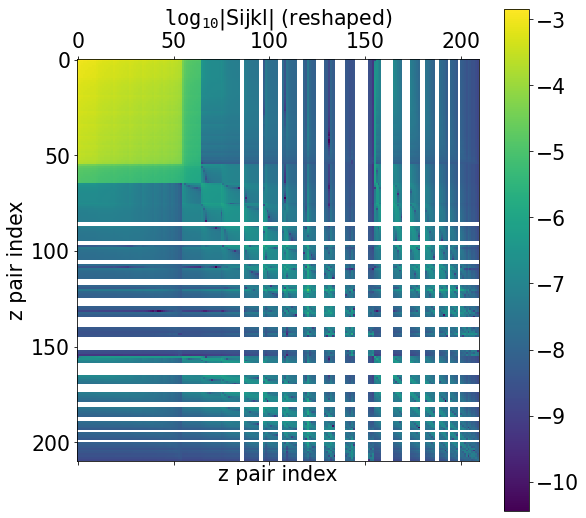

In [23]:
Sijkl_2D =  mm.Recast_Sijkl_3x2pt(Sijkl, zbins)[0] # Function taken by Fabien's GitHub notebooks
plt.matshow(np.log10(np.abs(Sijkl_2D)))
plt.colorbar()
plt.title("$\\tt{log_{10}}$|Sijkl| (reshaped)")
plt.xlabel("z pair index")
plt.ylabel("z pair index")

print('bins far enough apart have basically no overlap so the cross-spectra is zero.\
 If the overlap is small enough (<0.1% by default), the code sets Sijkl to zero')

## Step 2.2: compute SSC and G+SSC covariance matrices 

### Function for 3x2pt (again, massive speedup with  `@jit`)


In [24]:
Rl = my_config.Rl # probe response
start_time = time.time()

cov_WL_SSC  = mm.cov_SSC(nbl,    npairs, ind, C_LL, Sijkl, fsky, "WL", zbins, Rl)
cov_GC_SSC  = mm.cov_SSC(nbl,    npairs, ind, C_GG, Sijkl, fsky, "GC", zbins, Rl)
cov_WA_SSC  = mm.cov_SSC(nbl_WA, npairs, ind, C_WA, Sijkl, fsky, "WA", zbins, Rl)
cov_ALL_SSC = mm.cov_SSC_ALL(nbl, npairs_tot, ind, D_ALL, Sijkl, fsky, zbins, Rl)

########### ADDING NOSSC + SSC #####################

# sum Gauss + SSC
cov_WL_tot  = cov_WL_Gauss + cov_WL_SSC # WLonly
cov_GC_tot  = cov_GC_Gauss + cov_GC_SSC # GConly
cov_ALL_tot = cov_ALL_Gauss + cov_ALL_SSC # ALL
cov_WA_tot  = cov_WA_Gauss + cov_WA_SSC # WA

# reduce dimensions: 4D to 2D
cov_WL_tot_2D = mm.array_4D_to_2D(cov_WL_tot, nbl, npairs)
cov_WL_SSC_2D = mm.array_4D_to_2D(cov_WL_SSC, nbl, npairs)
cov_GC_tot_2D = mm.array_4D_to_2D(cov_GC_tot, nbl, npairs)
cov_GC_SSC_2D = mm.array_4D_to_2D(cov_GC_SSC, nbl, npairs)
cov_ALL_tot_2D = mm.array_4D_to_2D(cov_ALL_tot, nbl, npairs_tot)
cov_ALL_SSC_2D = mm.array_4D_to_2D(cov_ALL_SSC, nbl, npairs_tot)
cov_WA_tot_2D = mm.array_4D_to_2D(cov_WA_tot, nbl_WA, npairs)
cov_WA_SSC_2D = mm.array_4D_to_2D(cov_WA_SSC, nbl_WA, npairs)

print("Gaussian+SSC covariance matrices computed in %.2f seconds" %(time.time() - start_time))

Gaussian+SSC covariance matrices computed in 4.16 seconds


$$    Cov_{SSC}[C^{AB}_{ij}(\ell),C^{CD}_{kl}(\ell ')] \simeq R^{AB}(\ell)C^{AB}_{ij}(\ell)R^{CD}(\ell)C^{CD}_{kl}(\ell ')S^{A,B;C,D}_{i,j;k,l} \times f_{sky}^{-1} $$

__How to unpack the $S_{ijkl}$ matrix:__
<br>
$S^{A,B;C,D}_{i,j;k,l} $ 


$\downarrow $


`S[i,j,k,l]`

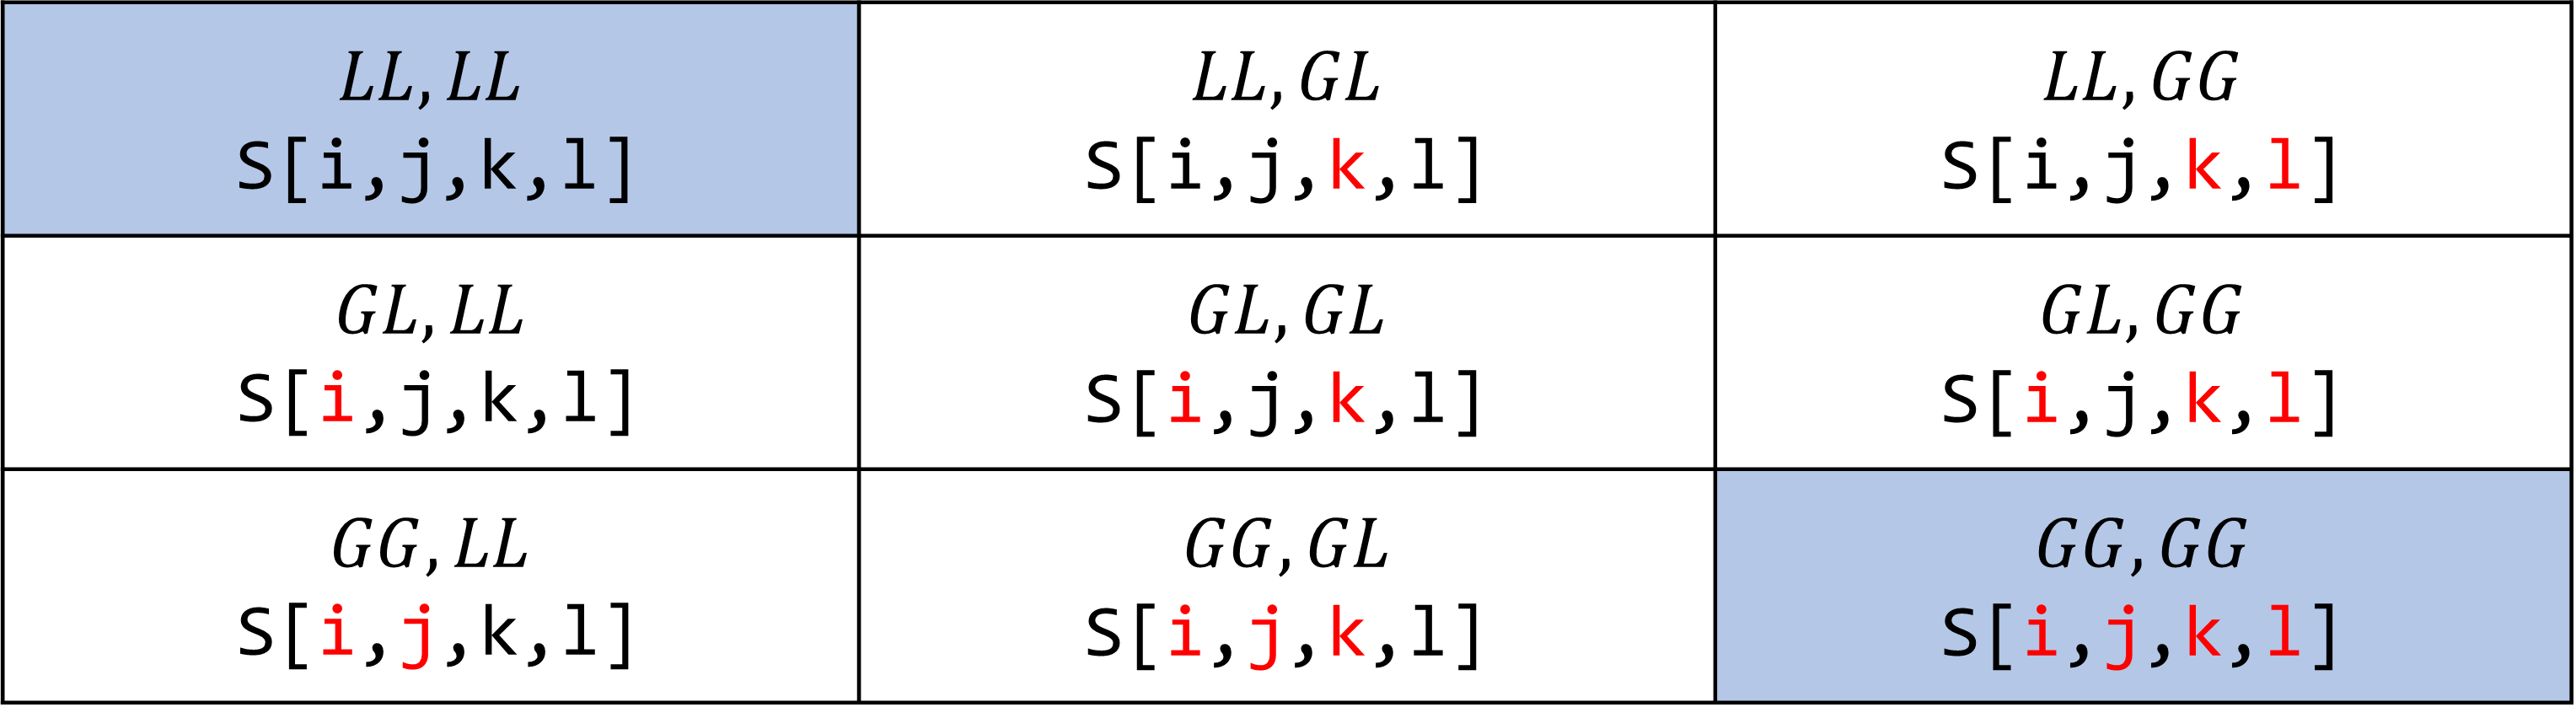

### with <font color='red'>i</font> = i + zbins
**blue blocks are for WL only and GCph only**

In [25]:
@jit(nopython=True)
def cov_SSC_ALL(nbl, npairs_tot, ind, D_ALL, Sijkl, fsky, zbins, Rl):
    
    cov_ALL_SSC = np.zeros((nbl, nbl, npairs_tot, npairs_tot))
    for ell1 in range(nbl):
        for ell2 in range(nbl):
            for p in range (npairs_tot):
                for q in range (npairs_tot):
                    #LL_LL
                    if ind[p,0] == 0 and ind[p,1] == 0 and ind[q,0] == 0 and ind[q,1] == 0:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2],ind[p,3],ind[q,2],ind[q,3]])
                    #LL_GL
                    elif ind[p,0] == 0 and ind[p,1] == 0 and ind[q,0] == 1 and ind[q,1] == 0:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2],ind[p,3],ind[q,2]+zbins,ind[q,3]])
                    #LL_GG
                    elif ind[p,0] == 0 and ind[p,1] == 0 and ind[q,0] == 1 and ind[q,1] == 1:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2],ind[p,3],ind[q,2]+zbins,ind[q,3]+zbins])
            
                    #GL_LL
                    elif ind[p,0] == 1 and ind[p,1] == 0 and ind[q,0] == 0 and ind[q,1] == 0:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2]+zbins,ind[p,3],ind[q,2],ind[q,3]])
                    #GL_GL
                    elif ind[p,0] == 1 and ind[p,1] == 0 and ind[q,0] == 1 and ind[q,1] == 0:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2]+zbins,ind[p,3],ind[q,2]+zbins,ind[q,3]])
                    #GL_GG
                    elif ind[p,0] == 1 and ind[p,1] == 0 and ind[q,0] == 1 and ind[q,1] == 1:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2]+zbins,ind[p,3],ind[q,2]+zbins,ind[q,3]+zbins])
            
                    #GG_LL
                    elif ind[p,0] == 1 and ind[p,1] == 1 and ind[q,0] == 0 and ind[q,1] == 0:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2]+zbins,ind[p,3]+zbins,ind[q,2],ind[q,3]])
                    #GG_GL
                    elif ind[p,0] == 1 and ind[p,1] == 1 and ind[q,0] == 1 and ind[q,1] == 0:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2]+zbins,ind[p,3]+zbins,ind[q,2]+zbins,ind[q,3]])
                    #GG_GG
                    elif ind[p,0] == 1 and ind[p,1] == 1 and ind[q,0] == 1 and ind[q,1] == 1:
                        cov_ALL_SSC[ell1,ell2,p,q] = (Rl*Rl*\
                        D_ALL[ell1, ind[p,0], ind[p,1], ind[p,2], ind[p,3]]*\
                        D_ALL[ell2, ind[q,0], ind[q,1], ind[q,2], ind[q,3]]*\
                        Sijkl[ind[p,2]+zbins,ind[p,3]+zbins,ind[q,2]+zbins,ind[q,3]+zbins])
                        
    cov_ALL_SSC /= fsky
    return cov_ALL_SSC

### Save matrices (npy, dat or txt)

In [26]:
# save SSC only in npy
# np.save(f"{path}/output/covmat/WL_SSC/covmatSSC_WLonly_lmin10_lmaxWL{ell_max_WL}_nbl{nbl}.npy" , cov_WL_SSC_2D)
# np.save(f"{path}/output/covmat/GC_SSC/covmatSSC_GConly_lmin10_lmaxGC{ell_max_GC}_nbl{nbl}.npy" , cov_GC_SSC_2D)
# np.save(f"{path}/output/covmat/ALL_SSC/covmatSSC_ALL_lmin10_lmaxXC{ell_max_XC}_nbl{nbl}.npy" ,   cov_ALL_SSC_2D)
# np.save(f"{path}/output/covmat/ALL_SSC/covmatSSC_WA_lmin10_lmaxWL{ell_max_WL}_nbl{nbl}.npy" ,    cov_WA_SSC_2D)

# save Gauss + SSC ("tot") in npy
np.save(f"{path}/output/covmat/common_ell_and_deltas/{Cij_folder}/demo/covmatTOT_WLonly_lmin10_lmaxWL{ell_max_WL}_nbl{nbl}.npy" , cov_WL_tot_2D)
np.save(f"{path}/output/covmat/common_ell_and_deltas/{Cij_folder}/demo/covmatTOT_GConly_lmin10_lmaxGC{ell_max_GC}_nbl{nbl}.npy" , cov_GC_tot_2D)
np.save(f"{path}/output/covmat/common_ell_and_deltas/{Cij_folder}/demo/covmatTOT_ALL_lmin10_lmaxXC{ell_max_XC}_nbl{nbl}.npy" ,   cov_ALL_tot_2D)
np.save(f"{path}/output/covmat/common_ell_and_deltas/{Cij_folder}/demo/covmatTOT_WA_lmin10_lmaxWL{ell_max_WL}_nbl{nbl}.npy" ,    cov_WA_tot_2D)
print('saved')

saved


<ipython-input-27-35e28c8ae7f0>:2: RuntimeWarning: divide by zero encountered in log10
  G     = ax1.matshow(np.log10(mm.array_4D_to_2D(cov_ALL_Gauss, nbl, npairs_tot)))
<ipython-input-27-35e28c8ae7f0>:2: RuntimeWarning: invalid value encountered in log10
  G     = ax1.matshow(np.log10(mm.array_4D_to_2D(cov_ALL_Gauss, nbl, npairs_tot)))
<ipython-input-27-35e28c8ae7f0>:3: RuntimeWarning: divide by zero encountered in log10
  G_SSC = ax2.matshow(np.log10(mm.array_4D_to_2D(cov_ALL_tot, nbl, npairs_tot)))
<ipython-input-27-35e28c8ae7f0>:3: RuntimeWarning: invalid value encountered in log10
  G_SSC = ax2.matshow(np.log10(mm.array_4D_to_2D(cov_ALL_tot, nbl, npairs_tot)))


size of the 3x2pt matrix: about 300 MB (nbl = 30, zbins = 10)


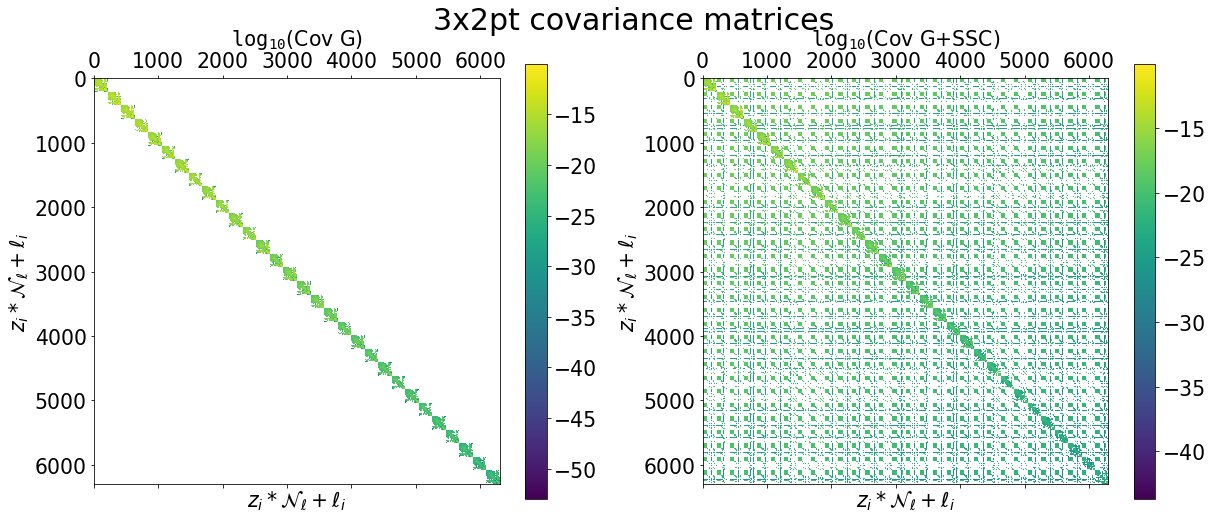

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
G     = ax1.matshow(np.log10(mm.array_4D_to_2D(cov_ALL_Gauss, nbl, npairs_tot)))
G_SSC = ax2.matshow(np.log10(mm.array_4D_to_2D(cov_ALL_tot, nbl, npairs_tot)))
ax1.set_title('$\\tt{log_{10}}$(Cov G)')
ax2.set_title('$\\tt{log_{10}}$(Cov G+SSC)')

label = r'$z_i*\mathcal{N}_\ell + \ell_i$'
ax1.set_xlabel(label)
ax1.set_ylabel(label)
ax2.set_xlabel(label)
ax2.set_ylabel(label)

plt.colorbar(G, ax=ax1)
plt.colorbar(G_SSC, ax=ax2)
fig.suptitle('3x2pt covariance matrices', fontsize=30)

print(r'size of the 3x2pt matrix: about 300 MB (nbl = %i, zbins = %i)' %(nbl, zbins))

# Code validation
### Goal: $\leq 10\%$ discrepancy w.r.t. mean in 1-$\sigma$ FM constraints


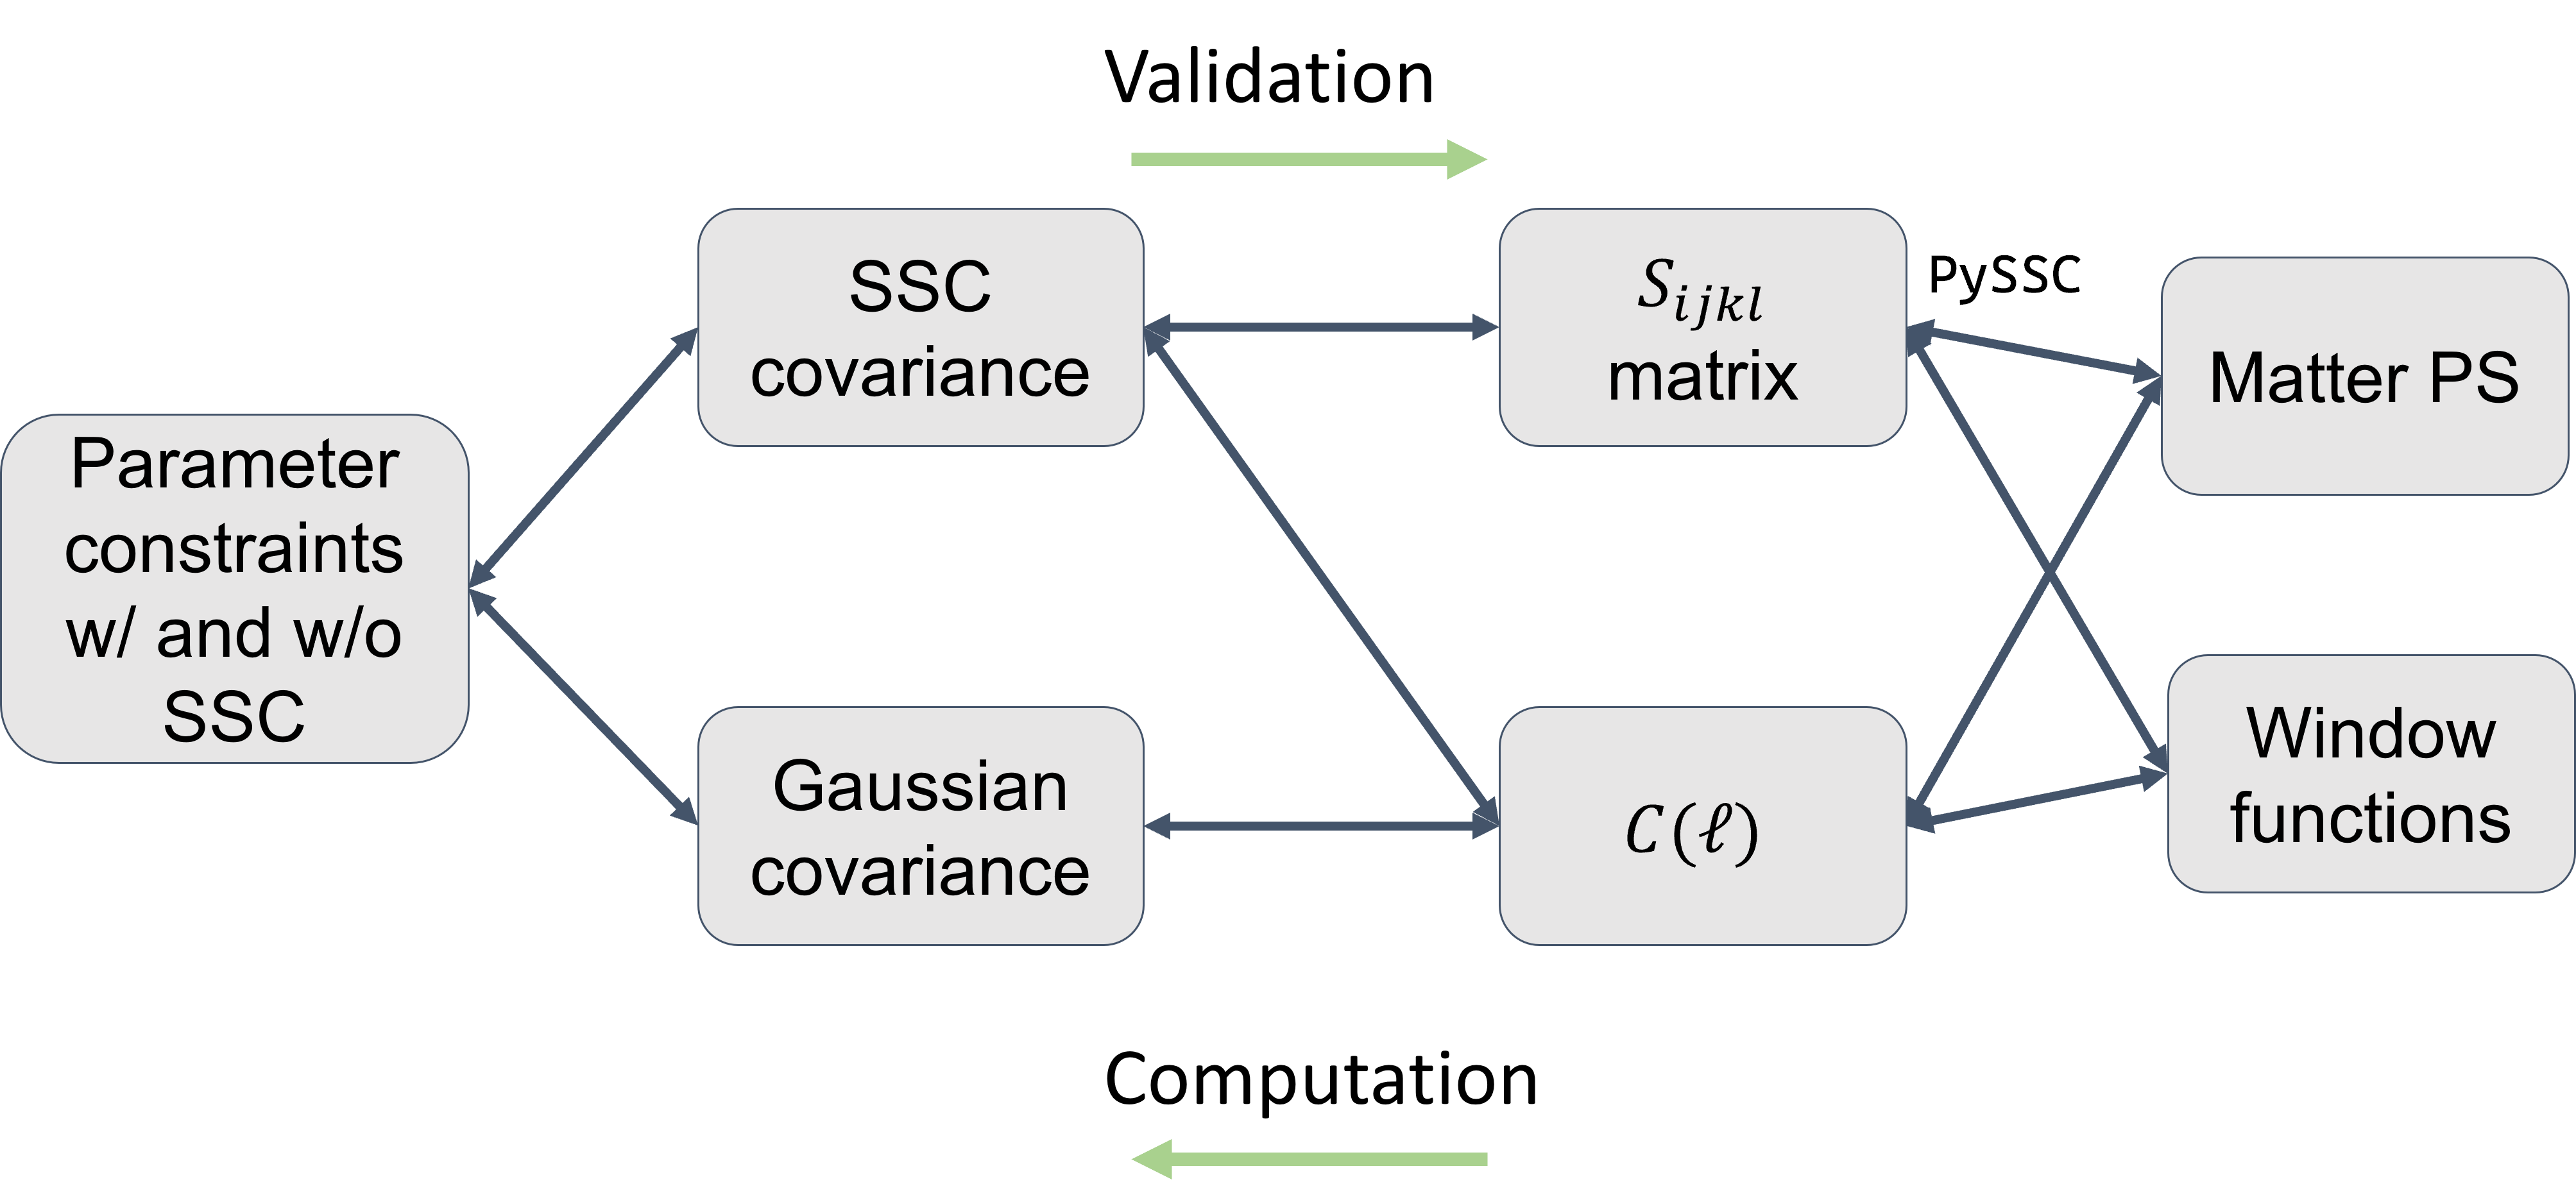

### Main discrepancies found:

* different conventions used in the definition of the WFs 
* different number of points in the $z$ grid when passing the WFs to PySSC
* presence/absence of the IA term
* different values of $\ell$ and corresponding $\Delta\ell$ (even with same no. of $\ell$ bins and same range $(\ell_{min}, \ell_{max})$)
* still issues with DE parameters in the Gaussian GCph case, already known to IST:F (due to computation of the derivatives for the FM)

## Results: Gauss only


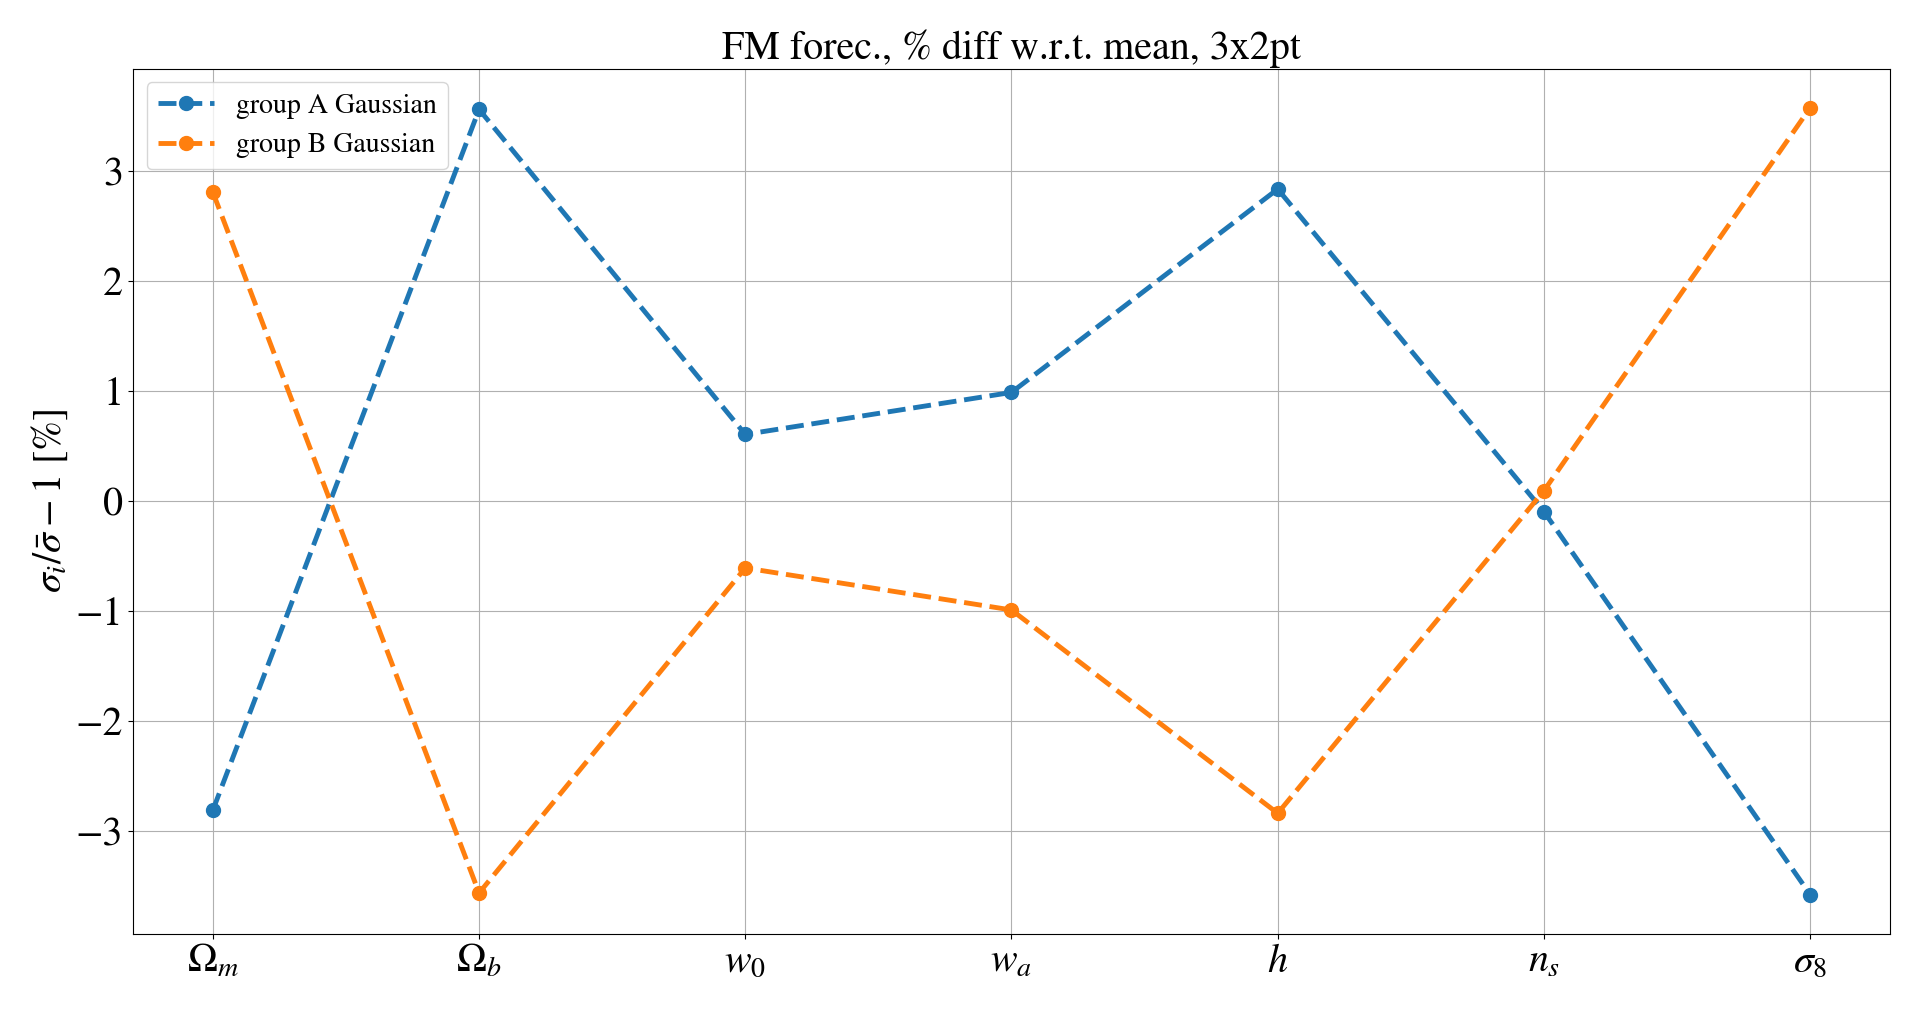

## Results: Gauss + SSC


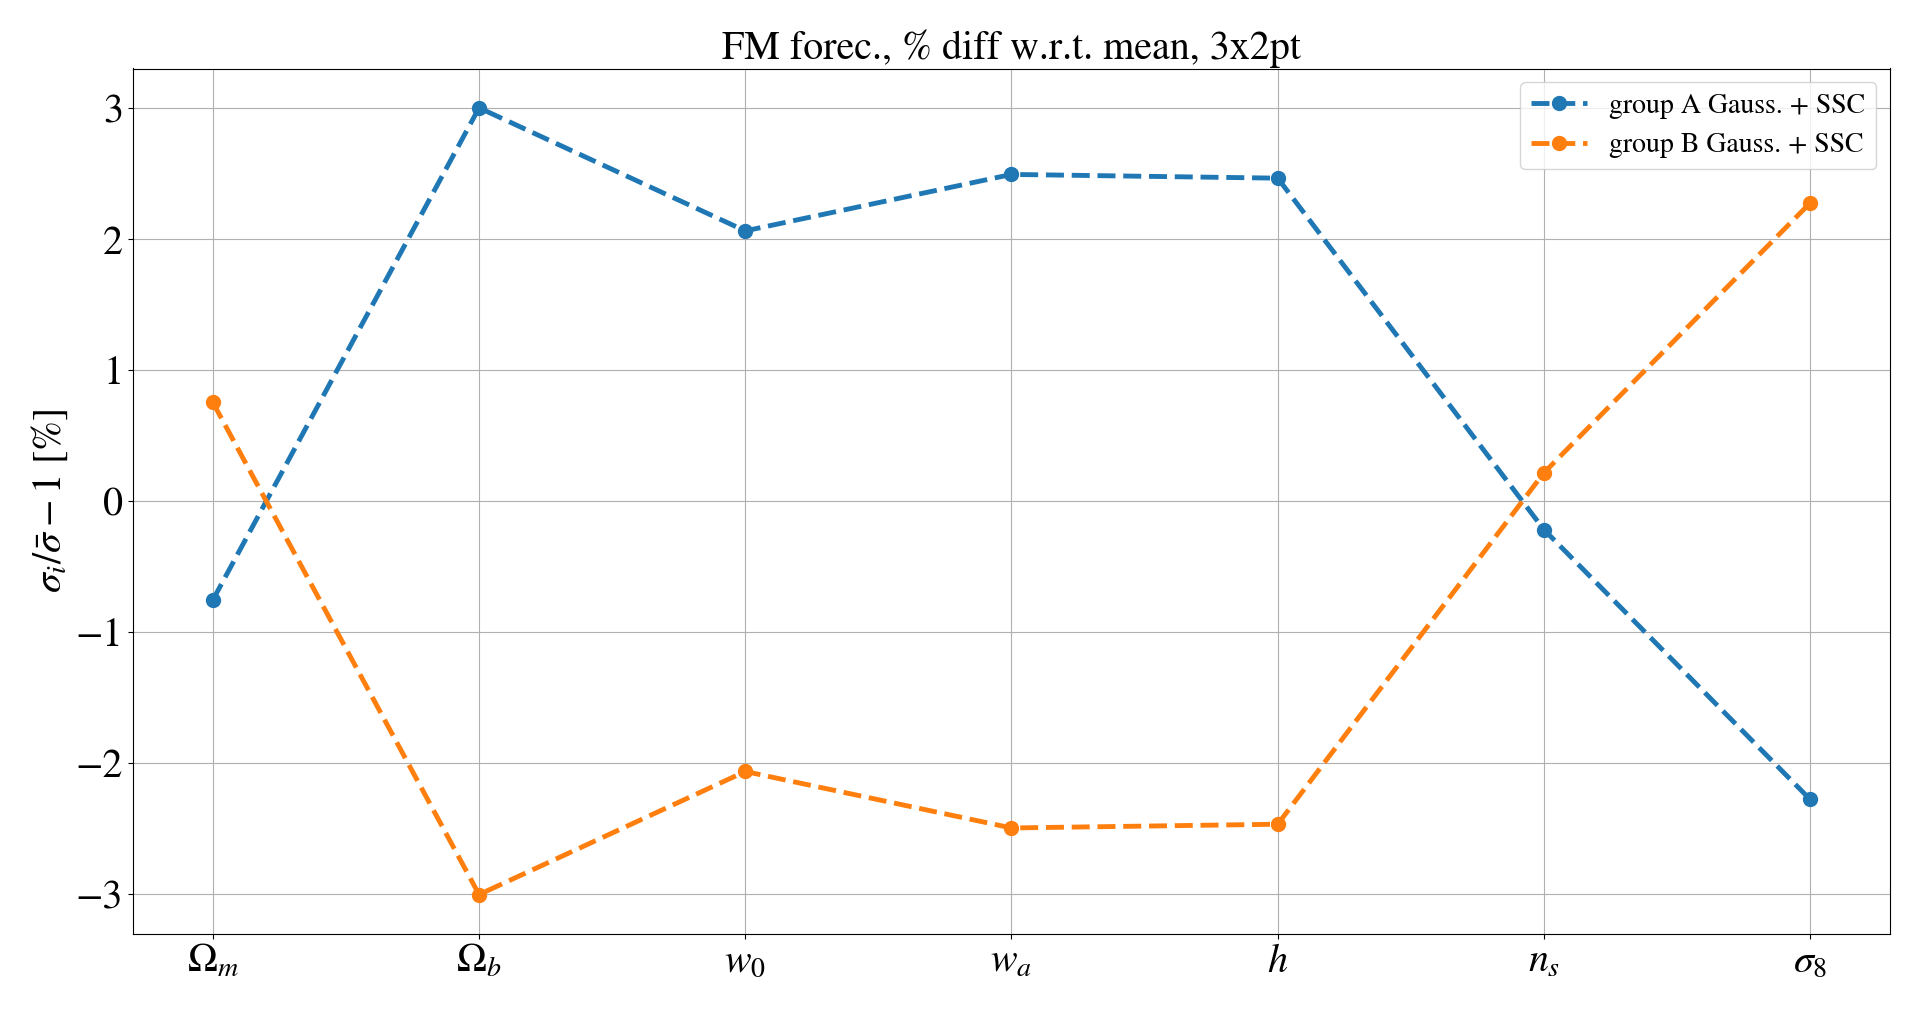

### Uncertainty increase 

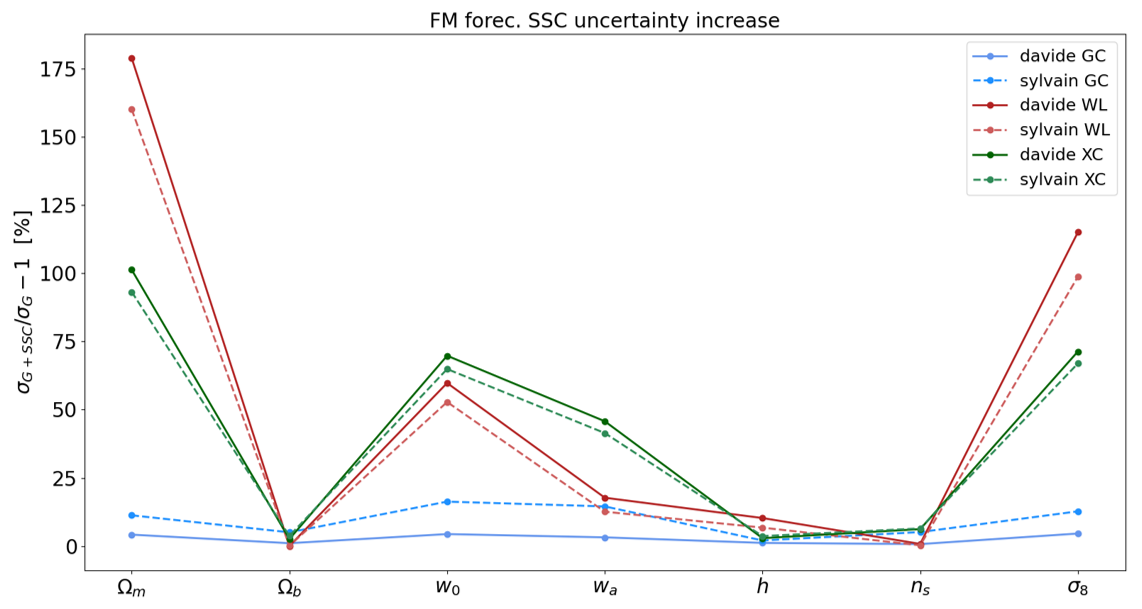

# Thank you

Full SSC:
$$Cov_{SSC}(\mathcal{O}_1,\mathcal{O}_2) = \int \int
\text d V_1\text d V_2 \dfrac{\partial \rho_1}{\partial \delta_b} (z_1) \dfrac{\partial \rho_2}{\partial \delta_b} (z_2) \sigma^2(z_1,z_2)$$
with $\rho_i$ comoving density of the observable $i$ (GCph or WL)